<a href="https://colab.research.google.com/github/eGamez01/cbm_plus/blob/add-initial-models/cbm_plus_ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CBM+ Applications

## Weibull and Gamma Distributions

Loaded 20,631 rows from train_FD001.txt
100 engines – life range 128-362 cycles

— Parameter fits —
Weibull  : β=4.409,  η=225.026
Gamma    : k=21.778, θ=9.473

— Model scores —
Weibull  LL=-530.75,  AIC=1065.50
Gamma    LL=-519.24, AIC=1042.48


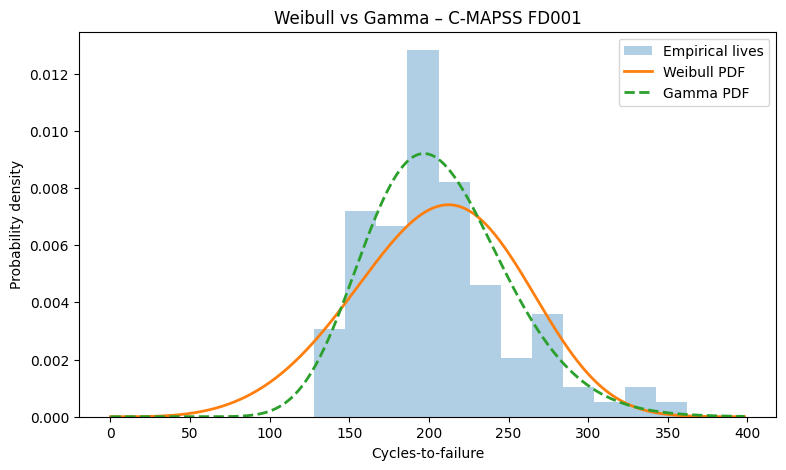

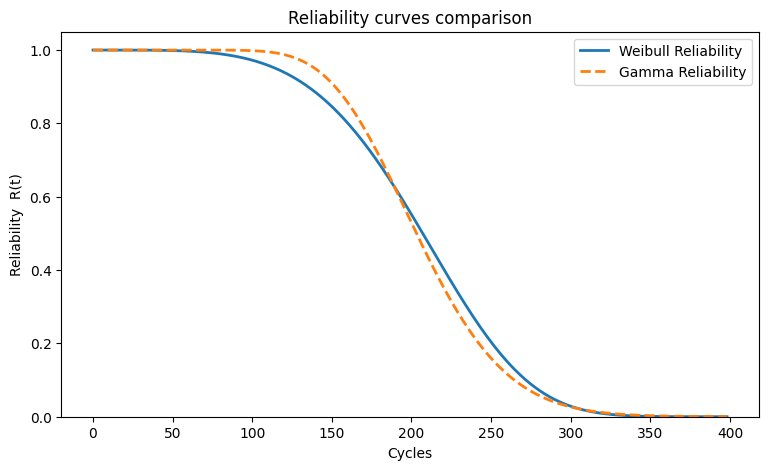

In [3]:
# -----------------------------------------------------------
# 0. Imports
# -----------------------------------------------------------
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import weibull_min, gamma

# -----------------------------------------------------------
# 1. Column layout (define BEFORE loading)
# -----------------------------------------------------------
cols = (["unit", "cycle"] +
        [f"op_setting_{i}" for i in range(1, 4)] +
        [f"s{i}"           for i in range(1, 22)])

# -----------------------------------------------------------
# 2. Read directly from the GitHub raw link
# -----------------------------------------------------------
SCENARIO  = "FD001"          # FD001 | FD002 | FD003 | FD004
base_url  = "https://raw.githubusercontent.com/eGamez01/lfs_data/refs/heads/master"
train_url = f"{base_url}/train_{SCENARIO}.txt"

# -----------------------------------------------------------
# 3. Load the training data
# -----------------------------------------------------------
train_df = pd.read_csv(train_url, sep=r"\s+", header=None, names=cols)
print(f"Loaded {train_df.shape[0]:,} rows from {train_url.split('/')[-1]}")


# -----------------------------------------------------------
# 3. Derive each engine’s life (cycles-to-failure)
# -----------------------------------------------------------
lifes = train_df.groupby("unit")["cycle"].max().to_numpy()
print(f"{lifes.size} engines – life range {lifes.min()}-{lifes.max()} cycles")

# -----------------------------------------------------------
# 4a. Weibull (2-param) fit
# -----------------------------------------------------------
beta, _, eta = weibull_min.fit(lifes, floc=0)        # shape, loc=0, scale
# 4b. Gamma (2-param) fit
k_gamma, _, theta_gamma = gamma.fit(lifes, floc=0)   # shape, loc=0, scale

# -----------------------------------------------------------
# 5. Optional: log-likelihood & AIC for quick comparison
# -----------------------------------------------------------
ll_weib  = weibull_min.logpdf(lifes, beta,      0, eta        ).sum()
ll_gamma = gamma      .logpdf(lifes, k_gamma,   0, theta_gamma).sum()
aic_weib  = 2*2 - 2*ll_weib       # 2 parameters (β,η)
aic_gamma = 2*2 - 2*ll_gamma      # 2 parameters (k,θ)

print("\n— Parameter fits —")
print(f"Weibull  : β={beta:.3f},  η={eta:.3f}")
print(f"Gamma    : k={k_gamma:.3f}, θ={theta_gamma:.3f}")
print("\n— Model scores —")
print(f"Weibull  LL={ll_weib:.2f},  AIC={aic_weib:.2f}")
print(f"Gamma    LL={ll_gamma:.2f}, AIC={aic_gamma:.2f}")

# -----------------------------------------------------------
# 6. Build PDF & Reliability curves for overlay
# -----------------------------------------------------------
t = np.linspace(0, lifes.max()*1.1, 400)

pdf_weib  = weibull_min.pdf(t,  beta,    0, eta)
pdf_gamma = gamma.pdf(       t, k_gamma, 0, theta_gamma)

rel_weib  = 1 - weibull_min.cdf(t, beta,    0, eta)
rel_gamma = 1 - gamma.cdf(       t, k_gamma, 0, theta_gamma)

# -----------------------------------------------------------
# 7. Plot PDF over histogram
# -----------------------------------------------------------
plt.figure(figsize=(9,5))
plt.hist(lifes, bins=12, density=True, alpha=.35, label="Empirical lives")
plt.plot(t, pdf_weib,  lw=2, label="Weibull PDF")
plt.plot(t, pdf_gamma, lw=2, label="Gamma PDF", ls="--")
plt.xlabel("Cycles-to-failure");  plt.ylabel("Probability density")
plt.title(f"Weibull vs Gamma – C-MAPSS {SCENARIO}")
plt.legend()
plt.show()

# -----------------------------------------------------------
# 8. Plot reliability curves on same axes
# -----------------------------------------------------------
plt.figure(figsize=(9,5))
plt.plot(t, rel_weib,  lw=2, label="Weibull Reliability")
plt.plot(t, rel_gamma, lw=2, label="Gamma Reliability", ls="--")
plt.xlabel("Cycles");  plt.ylabel("Reliability  R(t)")
plt.title("Reliability curves comparison")
plt.ylim(0, 1.05); plt.legend()
plt.show()

## LSTM Model

In [11]:
# ===========================================================
# 0. Imports & config  (run once)
# ===========================================================
import time, random, os, numpy as np, pandas as pd, tensorflow as tf
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras import layers, models

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# ===========================================================
# DATA PATHS – use raw-GitHub links
# ===========================================================
SCENARIO = "FD001"          # "FD001" | "FD002" | "FD003" | "FD004"
SEQ_LEN  = 30

base_url = (
    "https://raw.githubusercontent.com/"
    "eGamez01/lfs_data/refs/heads/master"
)

train_file = f"{base_url}/train_{SCENARIO}.txt"
test_file  = f"{base_url}/test_{SCENARIO}.txt"
rul_file   = f"{base_url}/RUL_{SCENARIO}.txt"

# Column names
cols = (["unit","cycle"] +
        [f"op_setting_{i}" for i in range(1,4)] +
        [f"s{i}" for i in range(1,22)])

# ===========================================================
# 1. Load & pre-process
# ===========================================================
train_df = pd.read_csv(train_file, sep=r"\s+", header=None, names=cols)
test_df  = pd.read_csv(test_file,  sep=r"\s+", header=None, names=cols)
rul_truth = pd.read_csv(rul_file,  header=None, names=["RUL_true"])


# Add RUL label to train set
max_cycle = train_df.groupby("unit")["cycle"].max()
train_df["RUL"] = train_df.apply(lambda r: max_cycle[r["unit"]] - r["cycle"], axis=1)

# Normalise 24 sensor + op-setting columns
feat_cols = cols[2:]
scaler    = MinMaxScaler()
train_df[feat_cols] = scaler.fit_transform(train_df[feat_cols])
test_df[feat_cols]  = scaler.transform(test_df[feat_cols])

# Make supervised windows
def make_windows(df, seq_len=30):
    X, y = [], []
    for uid, grp in df.groupby("unit"):
        grp = grp.sort_values("cycle")
        f   = grp[feat_cols].values
        r   = grp["RUL"].values if "RUL" in grp else None
        for i in range(len(grp)):
            win = f[max(0, i-seq_len+1):i+1]
            if len(win) < seq_len:
                win = np.pad(win, ((seq_len-len(win),0),(0,0)), 'constant')
            X.append(win)
            if r is not None: y.append(r[i])
    return np.asarray(X, np.float32), (np.asarray(y, np.float32) if y else None)

X_train, y_train = make_windows(train_df, SEQ_LEN)

# Last-row snapshot for each test engine
def last_snapshot(df, seq_len=30):
    X = []
    for _, grp in df.groupby("unit"):
        grp = grp.sort_values("cycle")
        seq = grp[feat_cols].tail(seq_len).values
        if len(seq) < seq_len:
            seq = np.pad(seq, ((seq_len-len(seq),0),(0,0)), 'constant')
        X.append(seq)
    return np.asarray(X, np.float32)


X_test = last_snapshot(test_df, SEQ_LEN)
y_test = rul_truth["RUL_true"].to_numpy(dtype=np.float32)

# ===========================================================
# 2. Build LSTM
# ===========================================================
model = models.Sequential([
    layers.Input(shape=(SEQ_LEN, len(feat_cols))),
    layers.Masking(mask_value=0.0),
    layers.LSTM(64, dropout=0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model.compile(optimizer='adam', loss='mae')

# ===========================================================
# 3. Train + time
# ===========================================================
tic = time.perf_counter()
hist = model.fit(X_train, y_train,
                 validation_split=0.1,
                 epochs=20, batch_size=64, verbose=0)
train_time = time.perf_counter() - tic

# ===========================================================
# 4. Predict + time
# ===========================================================
tic = time.perf_counter()
y_pred = model.predict(X_test, verbose=0).flatten()
pred_time = time.perf_counter() - tic

# Clip negatives
y_pred = np.clip(y_pred, 0, None)

# ===========================================================
# 5. Metrics
# ===========================================================
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred) * 100   # %
total_time = train_time + pred_time

# ===========================================================
# 6. Display results in comparison table format
# ===========================================================
result = pd.DataFrame([{
    "Model":          "LSTM",
    "R2":             f"{r2:.2f}%",
    "RMSE":           f"{rmse:.2f}",
    "time to train":  f"{train_time:.3f}",
    "time to predict":f"{pred_time:.3f}",
    "total time":     f"{total_time:.3f}"
}])

print(result.to_string(index=False))


Model     R2  RMSE time to train time to predict total time
 LSTM 31.98% 34.27       207.085           0.883    207.968


## Random Forest

In [ ]:
# ===========================================================
# Random Forest benchmark
# ===========================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time

# 1. Flatten 3-D sequences → 2-D feature matrices
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat  = X_test.reshape((X_test.shape[0],  -1))

# 2. Build & time the Random Forest
rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        n_jobs=-1,
        random_state=SEED,
        oob_score=False,
        verbose=0)

tic = time.perf_counter()
rf.fit(X_train_flat, y_train)
train_time_rf = time.perf_counter() - tic

tic = time.perf_counter()
y_pred_rf = rf.predict(X_test_flat)
pred_time_rf = time.perf_counter() - tic

# 3. Metrics
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf   = r2_score(y_test, y_pred_rf) * 100
total_rf = train_time_rf + pred_time_rf

# 4. Append to the comparison table
result = pd.concat([result, pd.DataFrame([{
    "Model":           "Random Forest",
    "R2":              f"{r2_rf:.2f}%",
    "RMSE":            f"{rmse_rf:.2f}",
    "time to train":   f"{train_time_rf:.3f}",
    "time to predict": f"{pred_time_rf:.3f}",
    "total time":      f"{total_rf:.3f}"
}])], ignore_index=True)

print(result.to_string(index=False))


##SVM

## KNN